# Notebook to showcase the basic functioning of the wfc3_dash module

Table of Contents: <br>
1. <a href='#imports'>Imports</a>
2. <a href='#introduction'>Introduction</a>
3. <a href='#downloads'>Downloading Relevant Data </a>
4. <a href='#DASH'>Running DASH </a> <br>
    a) <a href='#object'> Creating DashData object <br> </a>
    b) <a href='#diff_files'> Create diff files <br> </a>
    c) <a href='#asn_table'> Create association tables <br> </a>
    d) <a href='#subtract_flt'> Subtract background from original FLT <br> </a>
    e) <a href='#subtract_ext'> Subtract background from new FLT's <br> </a>
    f) <a href='#cosmic_rays'> Fix cosmic rays <br> </a>
    g) <a href='#align_each_other'> Align reads to each other <br> </a>
    h) <a href='#align_cat'> Align reads to catalog <br> </a>
    i) <a href='#align_both'> Align reads to each other, then to gaia catalog <br> </a>
5. <a href='#mosaic'> Creating Mosaic </a>

<a id='imports'></a>

## Imports

* *astroquery.mast Observations* used to download IMA files from the MAST HST archive
* *astropy.io import fits* used to open the files
* *matplotlib.pyplot* used to plot the images
* *numpy* used for some math

In [24]:
from astroquery.mast import Observations
from astropy.io import fits 
from astropy.table import Table
import matplotlib.pyplot as plt 
import numpy as np

%matplotlib notebook 

<a id='introduction'></a>

## Introduction

The wfc3_dash submodule of wfc3_tools is used to reduce the effects of the spacecraft drift for WFC3/IR images taken in DASH mode (i.e. under GYRO control, rather than under Fine-Guide-Sensor control)

This notebook works on a single .flt file but can be easily adapted to work on all exposures within a DASH visit or even a DASH program

<a id='downloads'></a>

## Downloading some relevant data

#### Get the table of observations associated to GO-14114 (PI van Dokkum, the first proposal to use the DASH mode)

In [2]:
obsTable = Observations.query_criteria(proposal_id=['14114'])

#### Get the full list of products associated to the table and restrict the list to IMA files

In [3]:
product_list = Observations.get_product_list(obsTable)
BM = (product_list['productSubGroupDescription']  == 'IMA') 
product_list = product_list[BM]

#### Display (part of) the IMA files list

In [4]:
product_list.show_in_notebook(display_length=5)

#### Pick a single exposure file to work on

In [25]:
myID = product_list['obsID'][0:1]

#### Download the IMA and FLT files for that exposure. The standard pipeline-FLT will be used for comparison with the detrended final product

In [6]:
download = Observations.download_products(myID,mrp_only=False,productSubGroupDescription=['IMA','FLT'])

INFO: Found cached file ./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits with expected size 126201600. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/icxe01tyq/icxe01tyq_flt.fits with expected size 16591680. [astroquery.query]


#### Display the results of the download operation

In [7]:
download

<Table length=2>
                   Local Path                    Status  Message  URL  
                     str47                        str8    object object
----------------------------------------------- -------- ------- ------
./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits COMPLETE    None   None
./mastDownload/HST/icxe01tyq/icxe01tyq_flt.fits COMPLETE    None   None

#### Read the files that were just downloaded locally 

In [27]:
#have path be everything minus last 8 characters (ima.fits)
localpathtofile = download['Local Path'][0][:-8]
localpathtofile

original_ima = fits.open(localpathtofile+'ima.fits')
original_flt = fits.open(localpathtofile+'flt.fits')
original_ima.info()

Filename: ./mastDownload/HST/icxe01tyq/icxe01tyq_ima.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     260   ()      
  1  SCI           1 ImageHDU        81   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        43   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        35   (1024, 1024)   int16   
  4  SAMP          1 ImageHDU        30   ()      
  5  TIME          1 ImageHDU        30   ()      
  6  SCI           2 ImageHDU        81   (1024, 1024)   float32   
  7  ERR           2 ImageHDU        43   (1024, 1024)   float32   
  8  DQ            2 ImageHDU        35   (1024, 1024)   int16   
  9  SAMP          2 ImageHDU        30   ()      
 10  TIME          2 ImageHDU        30   ()      
 11  SCI           3 ImageHDU        81   (1024, 1024)   float32   
 12  ERR           3 ImageHDU        43   (1024, 1024)   float32   
 13  DQ            3 ImageHDU        35   (1024, 1024)   int16   
 14  SAMP          

#### Plot the individual reads of the IMA file
Note: the individual 'SCI' extensions are stored in reverse order, with 'SCI', 1 corresponding to the last read

NSAMP 12


<IPython.core.display.Javascript object>


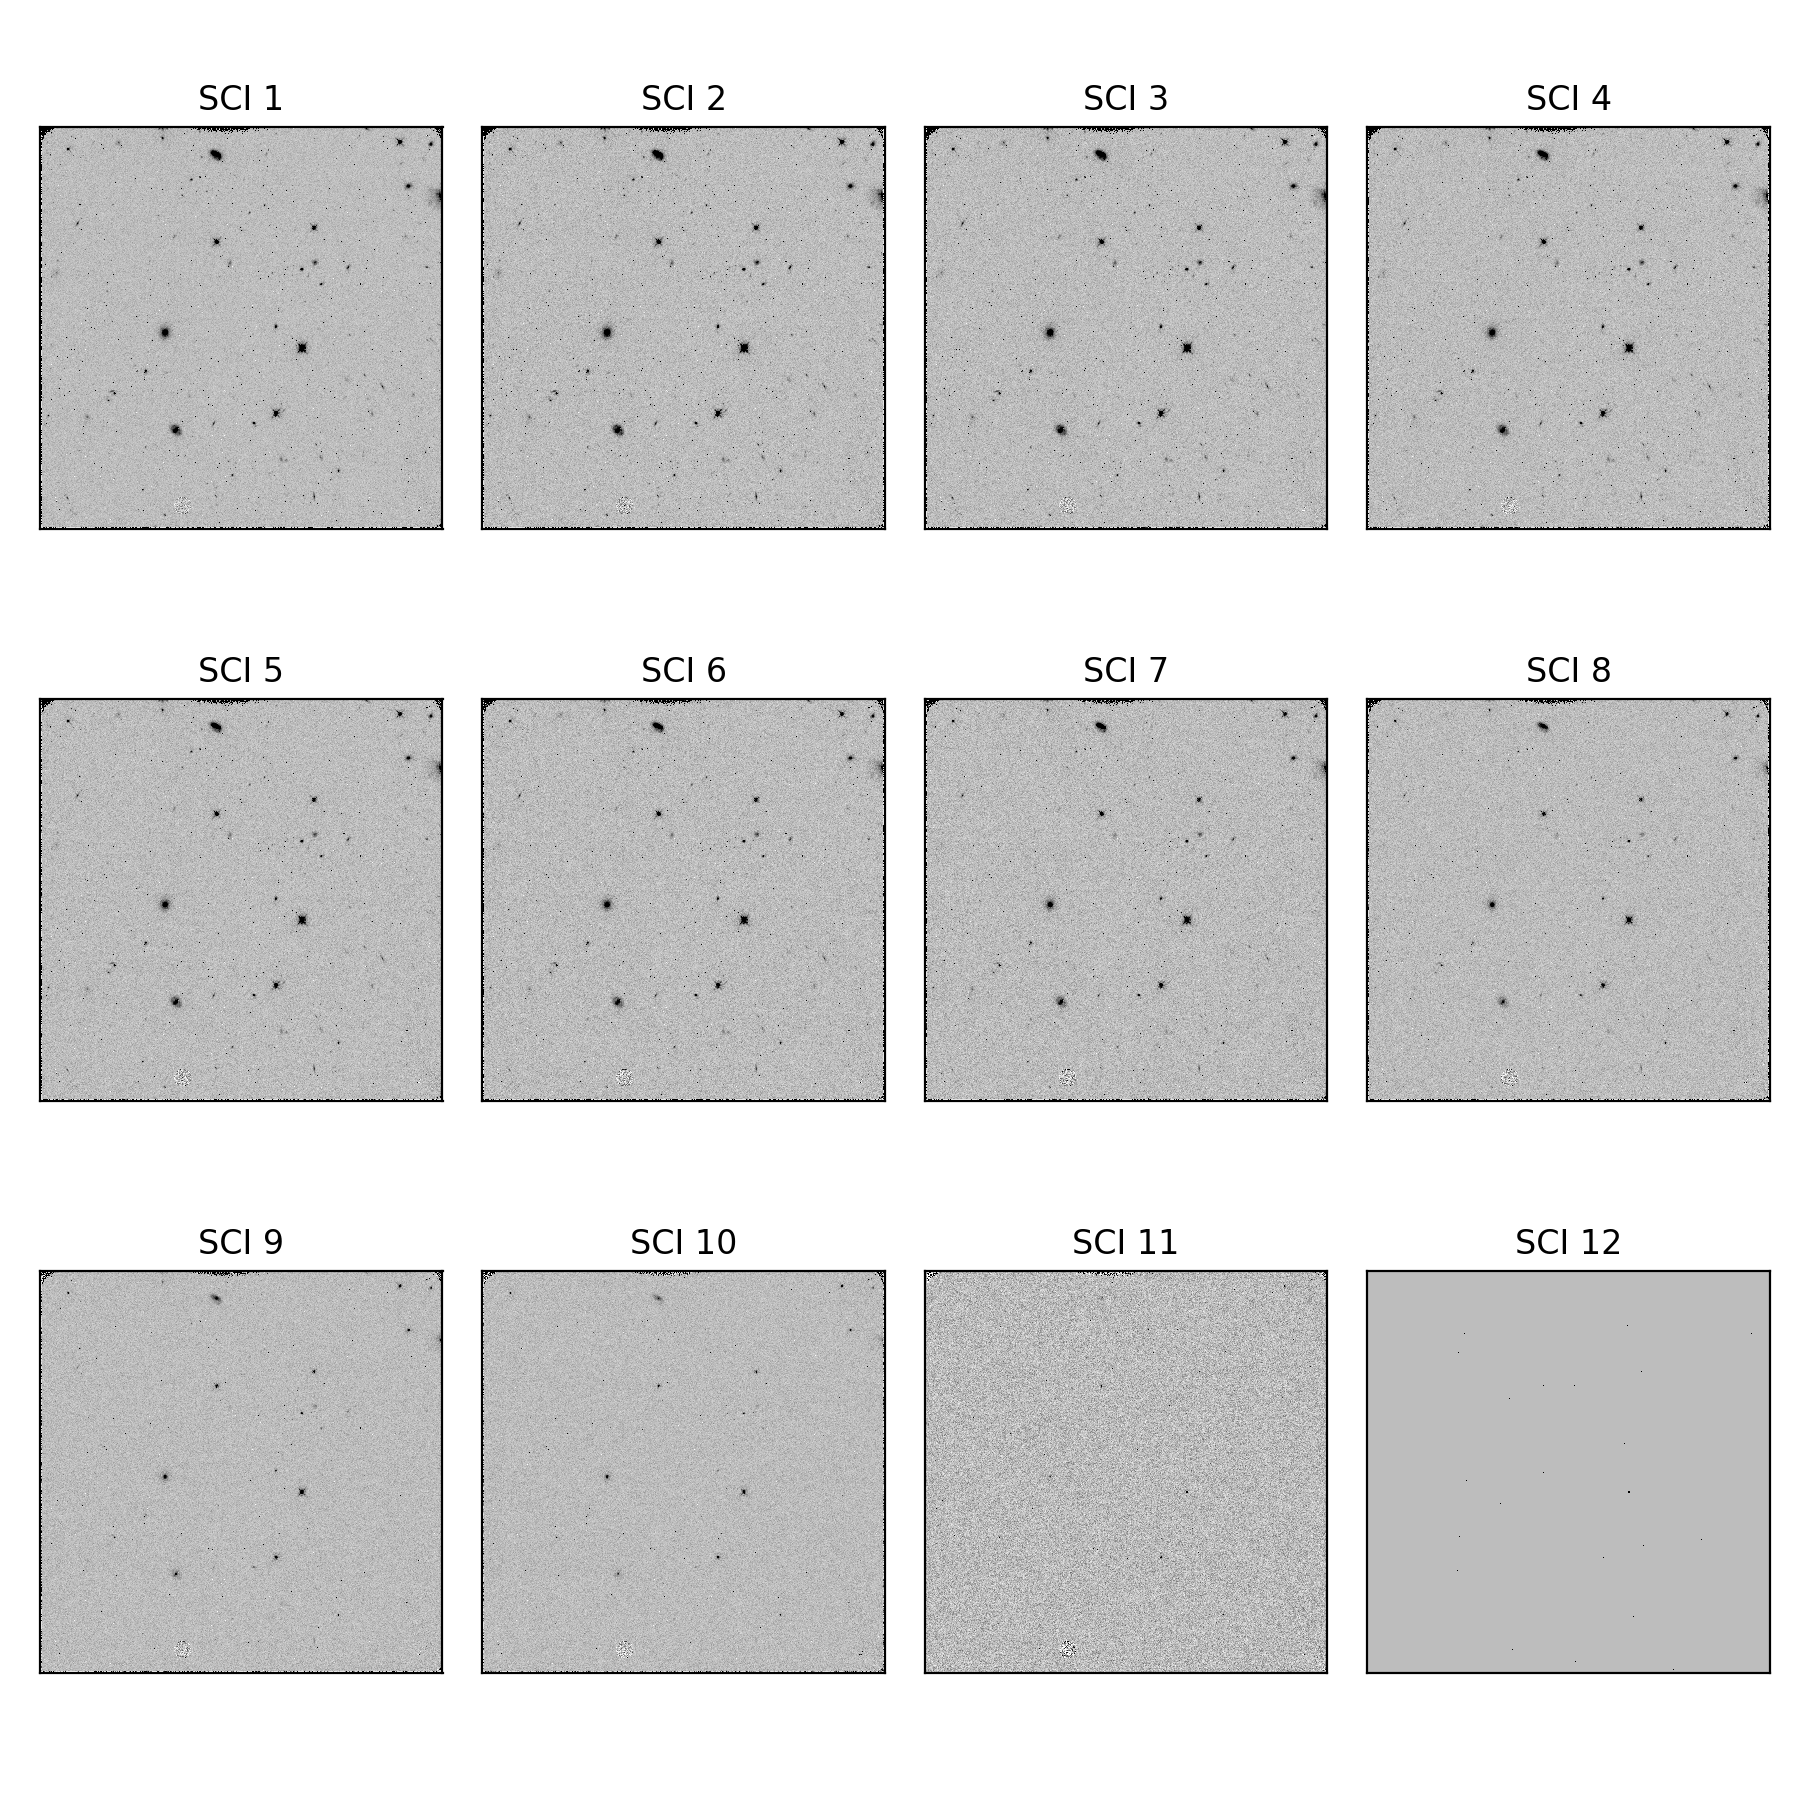

In [28]:
nsamp = original_ima[0].header['NSAMP']
print('NSAMP',nsamp)
fig,axarr = plt.subplots((nsamp+3)//4,4, figsize=(9,3*((nsamp+3)//4)))

for i in range(1,4*((nsamp+3)//4)+1):

    row = (i-1)//4
    col = (i-1)%4
    if (i <= nsamp):
        immed = np.nanmedian(original_ima['SCI',i].data)
        stdev = np.nanstd(original_ima['SCI',i].data)
        axarr[row,col].imshow(original_ima['SCI',i].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[row,col].set_title('SCI '+str(i))
        axarr[row,col].set_xticks([]) 
        axarr[row,col].set_yticks([]) 
    else:
        fig.delaxes(axarr[row,col])

fig.tight_layout()

<a id='DASH'></a>

## Run the individual steps of the DASH pipeline

Run the DASH pipeline for a single exposure.  
This procedure showcases the capabilities and customization options of the DASH pipeline.

#### This cell is inserted temporarily to allow for relative imports until the whole wfc3_dash submodule is properly packaged and installed within the wfc3_tools module

In [20]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from reduce_dash import DashData

<a id='object'></a>

### 1. Create a DashData object using the path to the ima file we have downloaded above

In [11]:
myDash = DashData(localpathtofile+'ima.fits', flt_file_name=localpathtofile+'flt.fits')

<a id='diff_files'></a>

### 2. Create diff files

A diff file contains the counts accumulated between two reads.  
The diff files are written to disk in a directory named ./diff under the current working directory (cwd).  
In creating diff files, the first difference, between the 1-st and 0-th read is ignored becuase of   
its very short expsoure time of 2.9 seconds, resulting in a noisy image.

In order to create a correct error extension, the split_ima() method calls the utils.get_flat() function and the utils.get_IDCtable function.  
The get_flat function reads the name of the flat field used for calibrating the ima images from the ima file header.  
The get_IDCtable reads the name of image distortion correction table, a reference file containing distortion coefficients that are used to correct for distortion in MAST drizzled data products.  
If the flat file is not present locally in a directory named ./iref under the cwd, get_flat() will download   
the flat field file from the CRDS database https://hst-crds.stsci.edu/unchecked_get/references/hst/ 
and place it in ./iref . Similarly for the IDC table.

In [12]:
myDash.split_ima()

Writing icxe01tyq_01_diff.fits
Writing icxe01tyq_02_diff.fits
Writing icxe01tyq_03_diff.fits
Writing icxe01tyq_04_diff.fits
Writing icxe01tyq_05_diff.fits
Writing icxe01tyq_06_diff.fits
Writing icxe01tyq_07_diff.fits
Writing icxe01tyq_08_diff.fits
Writing icxe01tyq_09_diff.fits
Writing icxe01tyq_10_diff.fits


#### Plot the diff files

Number of diff files 10


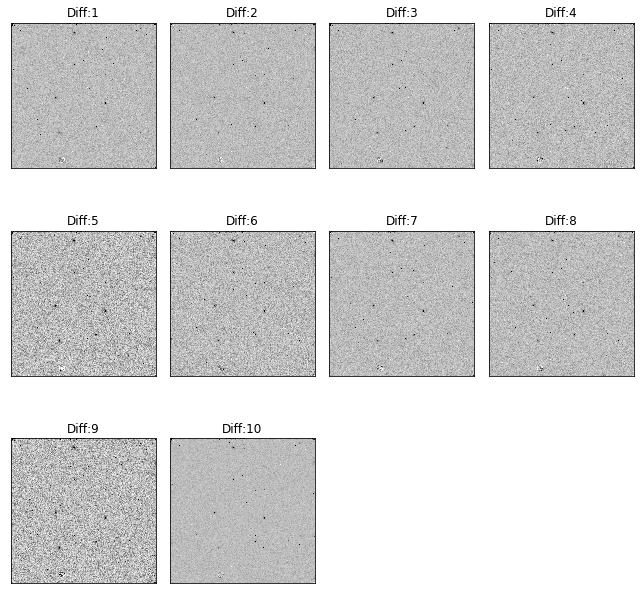

In [13]:
ndiff = len(myDash.diff_files_list)
print('Number of diff files',ndiff)
fig,axarr = plt.subplots((ndiff+3)//4,4, figsize=(9,3*((ndiff+3)//4)))

for i in range(4*((ndiff+3)//4)):

    row = (i)//4
    col = (i)%4
    if (i < ndiff):
        diff_i = fits.open(myDash.diff_files_list[i]+'_diff.fits')
        immed = np.nanmedian(diff_i['SCI'].data)
        stdev = np.nanstd(diff_i['SCI'].data)
        axarr[row,col].imshow(diff_i['SCI'].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[row,col].set_title('Diff:'+str(i+1))
        axarr[row,col].set_xticks([]) 
        axarr[row,col].set_yticks([]) 
    else:
        fig.delaxes(axarr[row,col])

fig.tight_layout()

<a id='asn_table'></a>

### 3. Create an association file

This file mimics a typical association file for dithered exposures, that is used by astrodrizzle   
to align and stack multiple exposures taken at the same sky position with small dithers.  
We exploit the fact that a WFC3/IR exposure taken under gyro control can be effectively split into   
individual pseudo-exposures (the diff images).  
Astrodrizzle can treat such pseudo-expsoures as individual dithers, and combine them.

In [14]:
myDash.make_pointing_asn()

#### Show the content of the asn file

In [15]:
asn_filename = 'diff/{}_asn.fits'.format(myDash.root)
asn_table = Table(fits.getdata(asn_filename, ext=1))
asn_table.show_in_notebook()

<a id='subtract_flt'></a>

### 4. Subtract Background from original FLT

This is necessary in order to create a drizzled science array and a segmentation map to help subtract the background from the diff files. <br>

In [16]:
myDash.subtract_background_flt()

<a id='subtract_ext'></a>

### 5. Subtract Background from diff files

Subtract background from the individual reads taken from the original IMA file using the DRZ and SEG imaged produced in the background subtraction of the original FLT.  
By default, this function will subtract the background and write it to the header. Setting parameter subtract to False will not subtract the background and only write it to the header.  
Set parameter reset_stars_dq to True to reset cosmic rays within objects to 0 (because the centers of the stars are flagged).

In [17]:
myDash.subtract_background_reads()

Segmentation image: diff/icxe01tyq_01_blot.fits
Background subtraction, diff/icxe01tyq_01_diff.fits:  0.6900041103363037
Background subtraction, diff/icxe01tyq_02_diff.fits:  0.6938582062721252
Background subtraction, diff/icxe01tyq_03_diff.fits:  0.7147378921508789
Background subtraction, diff/icxe01tyq_04_diff.fits:  0.6987603902816772
Background subtraction, diff/icxe01tyq_05_diff.fits:  0.7033610343933105
Background subtraction, diff/icxe01tyq_06_diff.fits:  0.6869426369667053
Background subtraction, diff/icxe01tyq_07_diff.fits:  0.6867339015007019
Background subtraction, diff/icxe01tyq_08_diff.fits:  0.6927986741065979
Background subtraction, diff/icxe01tyq_09_diff.fits:  0.6970295310020447
Background subtraction, diff/icxe01tyq_10_diff.fits:  0.6848157644271851


<a id='cosmic_rays'></a>

### 6. Fix Cosmic Rays

In [18]:
myDash.fix_cosmic_rays()

<a id='align_each_other'></a>

### 7a. Align reads to each other

Align reads to one another by aligning each to the first diff file.  
Uses TweakReg to update the WCS information in the headers of the diff files, then drizzles the images together using Astrodrizzle.  
Refer to documentation to customize parameters for TweakReg and AstroDrizzle.  

- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Re

Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icxe01tyq"
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
- IDCTAB: Distortion model from row 5 for chip 1 : F160W
Retrieving astrometrically-updated WCS "OPUS" for observation "icxe01tyq"
Retrieving astrometrically-updated WCS "ID

  #  Source finding for '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff.fits', EXT=('SCI', 1) started at: 15:14:06.825 (22/07/2019)
     Found 83 objects.
===  FINAL number of objects in image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff.fits': 83

===  Source finding for image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff.fits':
  #  Source finding for '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff.fits', EXT=('SCI', 1) started at: 15:14:07.068 (22/07/2019)
     Found 152 objects.
===  FINAL number of objects in image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff.fits': 152

===  Source finding for image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits':
  #  Source finding for '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits', EXT=('SCI', 1) started at: 15:14:07.30 (22

CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544214734974191
ORIENTAT : 179.6294739673506
WCSNAME  :  DASH

Performing fit for: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits

Matching sources from '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits' with sources from reference image '/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -0.2105, 0 with significance of 15 and 19 matches
Found 16 matches for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits : 
XSH: 0.0083  YSH: -0.0089    ROT: 0.0008573102584    SCALE: 1.000015
FIT XRMS: 0.021      FIT YRMS: 0.031  
FIT RMSE: 0.038      FIT MAE: 0.031  

RMS_RA: 7.3e-07 (deg)   RMS_DEC: 1.1



Processing /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits['SCI',1]

Updating header for /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits[1]
WCS Keywords

CD_11  CD_12: 3.762252963431498e-05 2.1639708213971915e-07
CD_21  CD_22: 1.1638982603444539e-07 -3.3603457590411793e-05
CRVAL    : 150.22854521133948 1.7130616679690542
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544214734974191
ORIENTAT : 179.63103594070338
WCSNAME  :  DASH
Writing out shiftfile : shifts_icxe01tyq.txt
Trailer file written to:  tweakreg.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.0.2 (2019-05-28 16:51:22 -0400) started at: 15:14:17.271 (22/07/2019)

==== Processing Step  Initialization  started at  15:14:17.273 (22/07/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.22865296251905  1.7127555071603462  
CRPIX : 542.0  479.5  
CD1_1 CD1_2  : 3.5625000794728146e-05  5.573391447

-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff_single_sci.fits
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff_single_sci.fits
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff_single_sci.fits
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff_single_sci.fits
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_07_diff_single_sci.fits
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff_single_sci.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_03_diff_single_sci.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff_single_sci.fits
Writing out image 

Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_08_diff_sci1_blt.fits
    Blot: creating blotted image:  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff_sci1_blt.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_09_diff_sci1_blt.fits
    Blot: creating blotted image:  /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff_sci1_blt.fits
Writing out image to disk: /Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_10_diff_sci1_blt.fits
==== Processing Step  Blot  finished at  15:14:29.109 (22

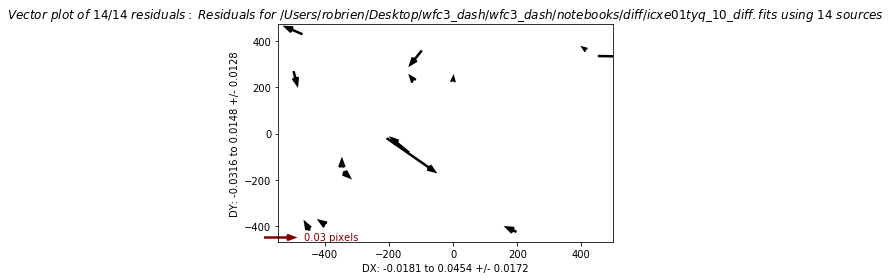

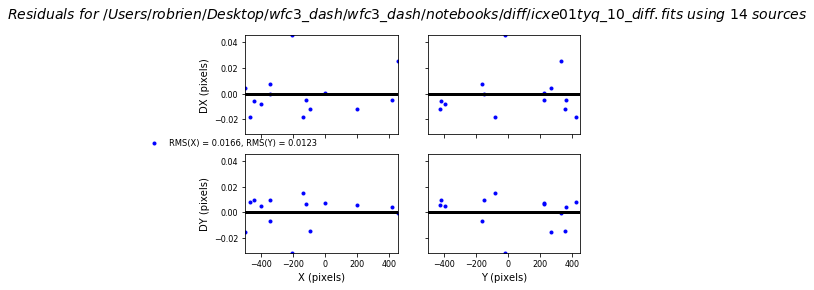

In [21]:
myDash.align(updatehdr=False)

Print the shifts file to analyze how well the alignment went.  
Do not update header until shifts are satisfactory. 

In [29]:
print(open('shifts_icxe01tyq.txt').read())

# frame: output
# refimage: shifts_icxe01tyq_wcs.fits[wcs]
# form: delta
# units: pixels
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_01_diff.fits    0.000000  0.000000    0.000000     1.000000   0.000000  0.000000
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_02_diff.fits    -0.000720  -0.001926    0.000510     1.000011   0.027334  0.026079
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_03_diff.fits    0.009074  0.006677    359.999662     1.000006   0.023159  0.021129
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_04_diff.fits    0.002682  0.002303    359.999698     1.000008   0.014710  0.020283
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_05_diff.fits    0.006010  -0.003462    359.998253     1.000008   0.020450  0.013749
/Users/robrien/Desktop/wfc3_dash/wfc3_dash/notebooks/diff/icxe01tyq_06_diff.fits    0.008332  -0.008939    0.000857     1.000015   0.020572  0.031460
/Users/

Update header and WCS information, then plot final drizzled image.

In [ ]:
myDash.align()

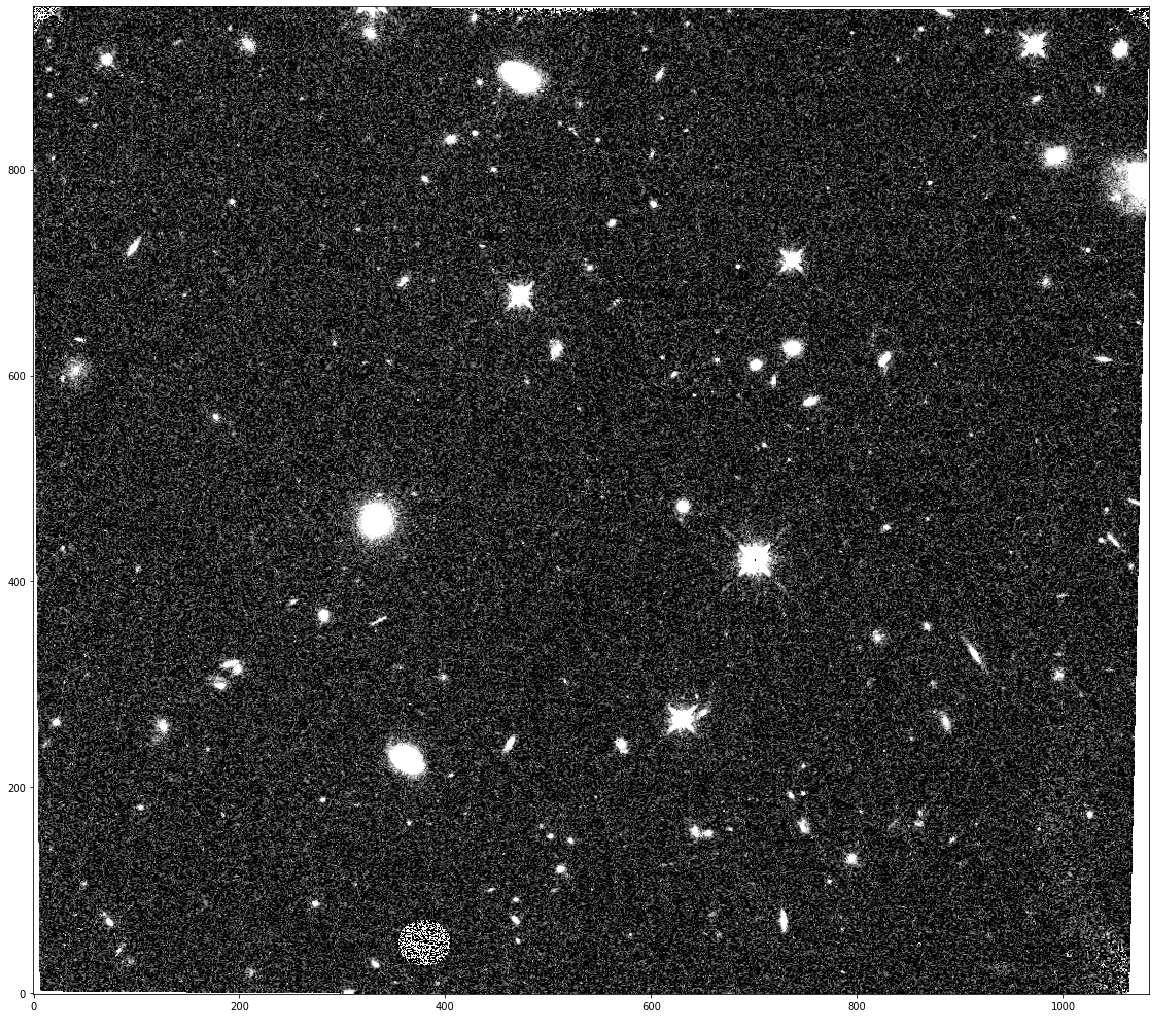

In [23]:
sci = fits.getdata('final_drz_sci.fits')

fig = plt.figure(figsize=(20, 20))

plt.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')

<a id='align_cat'></a>

### 7b. Align reads to Gaia<br> 
(procedure taken from https://github.com/spacetelescope/gaia_alignment)

Aligns reads Gaia.

#### Determine coordinates and search area from the WCS's of your images.

Import packages.

In [ ]:
import glob
import matplotlib as mpl

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import wcsaxes
from astropy.coordinates.sky_coordinate import SkyCoord

from astroquery.skyview import SkyView

from matplotlib.patches import Polygon
import matplotlib.cm as cm

%matplotlib inline

Get the WCS information from each input image.

In [ ]:
#use coordinates of original exposure
def get_footprints(im_name):
    """Calculates positions of the corners of the science extensions of some image 'im_name' in sky space"""
    footprints = []
    hdu = fits.open(im_name)
    
    flt_flag = 'flt.fits' in im_name or 'flc.fits' in im_name
    
    # Loop ensures that each science extension in a file is accounted for. 
    for ext in hdu:
        if 'SCI' in ext.name:
            hdr = ext.header
            wcs = WCS(hdr, hdu)
            footprint = wcs.calc_footprint(hdr, undistort=flt_flag)
            footprints.append(footprint)
    
    hdu.close()
    return footprints

Record the positions (in RA and DEC) of all the corners of the images in sky space. Take the min, max, and midpoints of each dimensions to determine where and how wide we want to query our coordinates.

In [ ]:
def bounds(footprint_list):
    """Calculate RA/Dec bounding box properties from multiple RA/Dec points"""
    
    # flatten list of extensions into numpy array of all corner positions
    merged = [ext for image in footprint_list for ext in image]
    merged = np.vstack(merged)
    ras, decs = merged.T
    
    # Compute width/height
    delta_ra = (max(ras)-min(ras))
    delta_dec = max(decs)-min(decs)

    # Compute midpoints
    ra_midpt = (max(ras)+min(ras))/2.
    dec_midpt = (max(decs)+min(decs))/2.
    

    return ra_midpt, dec_midpt, delta_ra, delta_dec

Determine and save the coordinates.

In [ ]:
images = glob.glob('diff/*_diff.fits')
footprint_list = list(map(get_footprints, images))

ra_midpt, dec_midpt, delta_ra, delta_dec = bounds(footprint_list)

coord = SkyCoord(ra=ra_midpt, dec=dec_midpt, unit=u.deg)
print(coord)

#### Querying from Gaia

With the coordinates calculated, we now only need to give the search area and perform the query.  Most astroquery supported missions/databases can be passed width/height (for a rectangular search) or a radius (for a circular search).  In either case, these parameters can be passed using astropy.units Quantity 

In [ ]:
from astropy.units import Quantity
from astroquery.gaia import Gaia

width = Quantity(delta_ra, u.deg)
height = Quantity(delta_dec, u.deg)

Perfom the query.

In [ ]:
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

#### Aligning Data to Catalog

In [ ]:
from astropy.table import Table

ras = r['ra']
decs = r['dec']
mags = r['phot_g_mean_mag']
ra_error = r['ra_error']
dec_error = r['dec_error']

tbl = Table([ras, decs]) # Make a temporary table of just the positions
tbl.write('gaia.cat', format='ascii.fast_commented_header') # Save the table to a file.  The format argument ensures
                                                            # the first line will be commented out.

In [ ]:
thresh = 10.

def get_error_mask(catalog, max_error):
    """Returns a mask for rows in catalog where RA and Dec error are less than max_error"""
    ra_mask = catalog['ra_error']< max_error
    dec_mask = catalog['dec_error'] < max_error
    mask = ra_mask & dec_mask
#     print('Cutting sources with error higher than {}'.format(max_error))
#     print('Number of sources befor filtering: {}\nAfter filtering: {}\n'.format(len(mask),sum(mask)))
    return mask

mask = get_error_mask(r, thresh)

tbl_filtered = Table([ras[mask], decs[mask]]) 
tbl.write('gaia_filtered_{}_mas.cat'.format(thresh), format='ascii.fast_commented_header')

#### Align images. <br>
Parameters ref_catalog and ref_image denote the reference catalog and reference image, respectively.  
Note: Must be connected to STScI network in order to align to Gaia (specifically to use updatewcs function on the input images for TweakReg). To not use this function, set parameter updatewcsfn to False.

If an error arises, try lowering the threshold.

In [ ]:
myDash.align(align_method='CATALOG', ref_catalog='gaia.cat', 
             wcsname='GAIA', threshold=10., searchrad=1000., cw=5., updatehdr=False)

Inspect the shifts file to see if method used produced sufficient results. Notice that some diff files could not sufficiently line up with Gaia. It is up to the user to determine whether this is sufficient or not.

In [ ]:
print(open('shifts_icxe01tyq.txt').read())

Update header and plot aligned science images.

In [ ]:
myDash.align(align_method='CATALOG', ref_catalog='gaia.cat', 
             wcsname='GAIA', threshold=10., searchrad=1000., cw=5.)

In [ ]:
sci = fits.getdata('final_drz_sci.fits')

fig = plt.figure(figsize=(20, 20))

plt.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')

<a id='align_both'></a>

### 7c. Align reads to each other, then align final read to Gaia

Will most likely give better results, especially if not enough sources are found using catalog method alone.

Align sources to each other using TweakReg.

In [ ]:
myDash.align(astrodriz=False)

Align updated images to Gaia.

In [ ]:
myDash.align(align_method='CATALOG', ref_catalog='gaia.cat', wcsname='GAIA',
             threshold=10., searchrad=1000., cw=5.)

Inspect the shifts file to see if method used produced sufficient results. Then plot final drizzled image.

In [ ]:
print(open('shifts_icxe01tyq.txt').read())

In [ ]:
sci = fits.getdata('final_drz_sci.fits')

fig = plt.figure(figsize=(20, 20))

plt.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')

<a id='mosaic'></a>

## Using main function to create mosaic

Creates mosaic from multiple exposures using DashData class.

In [ ]:
myDash.main()